# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd

from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from pandas.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# **Load Data**

In [2]:
data=pd.read_csv("/content/drive/MyDrive/Datasets/Cancer.csv")

In [3]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

All features are complete, only 'Unnamed: 32' is completely null, probably an error in the dataset, let's drop the unnecessary data.

In [5]:
data.drop(['Unnamed: 32','id'], axis = 1 , inplace=True)

In [6]:
data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


# **Exploratory Data Analysis (EDA)**

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


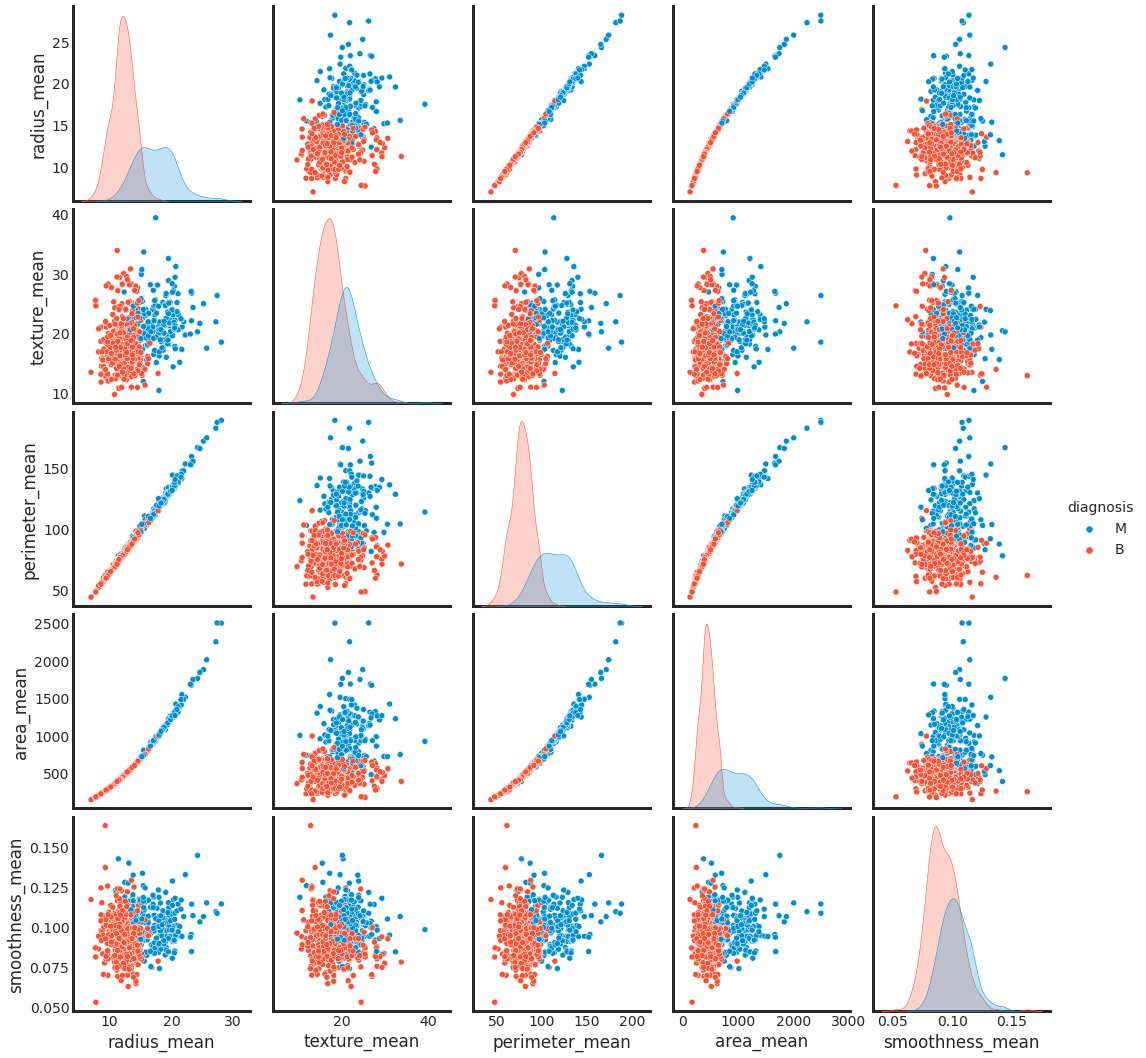

In [7]:
#Visualizing Multidimensional Relationships
plt.style.use('fivethirtyeight')
sns.set_style("white")
sns.pairplot(data[[data.columns[0], data.columns[1],data.columns[2],data.columns[3],
                     data.columns[4], data.columns[5]]], hue = 'diagnosis' , size=3)

Text(0.5, 0.98, 'Correlation Matrix')

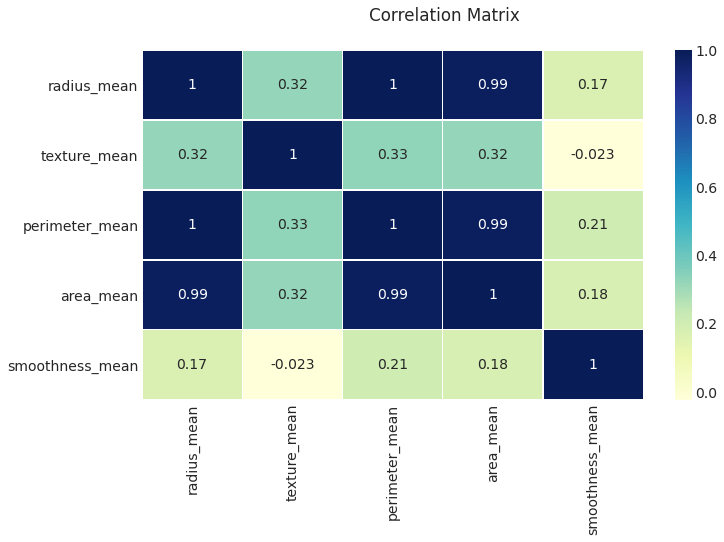

In [8]:
#create the correlation matrix heat map
plt.figure(figsize=(10,6))
sns.heatmap(data[[data.columns[0], data.columns[1],data.columns[2],data.columns[3],
                     data.columns[4], data.columns[5]]].corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);
plt.suptitle('Correlation Matrix')

## **Data Preprocessing**

In [10]:
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

#Scalling
scaler =MinMaxScaler(feature_range=(0, 1))
scaled_data =  pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Split the data to train and test sets
X = scaled_data.loc[:, scaled_data.columns != 'diagnosis']
y = scaled_data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((455, 30), (455,), (114, 30), (114,))

# **Model Evaluation Metrics**

In [11]:
def getModelEvaluationMetrics(classifier, model_name: str, x_test: pd.core.frame.DataFrame,
                              y_test: pd.core.frame.DataFrame, y_predicted, plot_confusion_matrix=False,
                              figsize=(10, 8)) -> np.ndarray:

    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted)
    print('Confusion matrix:\n\n {0}'.format(conf_mat))

    if plot_confusion_matrix:
        labels = ['M', 'B']
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        cax = ax.matshow(conf_mat, cmap=plt.cm.Reds)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.style.use('fivethirtyeight')
        sns.set_style("white")
        plt.xlabel('Predicted')
        plt.ylabel('Expected')
        plt.title(f'Confusion Matrix for {model_name}', fontweight='bold')
        plt.show()

    # Calculating the precision (tp/tp+fp)
    precision = str(np.round((conf_mat[1][1] / (conf_mat[1][1] +
                              conf_mat[0][1])) * 100, 2))
    print('The precision is: {0} %'.format(precision))

    # Calculating the recall (tp/tp+fn)
    recall = str(np.round((conf_mat[1][1] / (conf_mat[1][1] +
                           conf_mat[1][0])) * 100, 2))
    print('The recall is: {0} %'.format(recall))

    return conf_mat

In [12]:
def createROCAnalysis(classifier, model_name: str, y_test: pd.core.series.Series, pred_probs: np.ndarray,
                      plot_ROC_Curve=False, figsize=(10, 8)) -> int:
   
    if plot_ROC_Curve:
        plt.figure(figsize=figsize)
        plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill Classifier')
        fp_rate, tp_rate, _ = roc_curve(y_test, pred_probs[:, 1])
        plt.plot(fp_rate, tp_rate, marker='.', label=model_name)
        plt.style.use('fivethirtyeight')
        sns.set_style("white")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}', fontweight='bold')
        plt.grid(True, alpha=0.1, color='black')
        plt.legend(loc='lower right')
        plt.show()

    # Calculate Area Under Curve (AUC) for the Receiver Operating
    # Characteristics Curve (ROC)
    auc_score = np.round(roc_auc_score(y_test, pred_probs[:, 1]), 4)
    print(f'{model_name} - ROC AUC score: {auc_score}')

    return auc_score

# Breast Cancer Prediction

In [13]:

rf_class = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Confusion matrix:

 [[69  2]
 [ 3 40]]


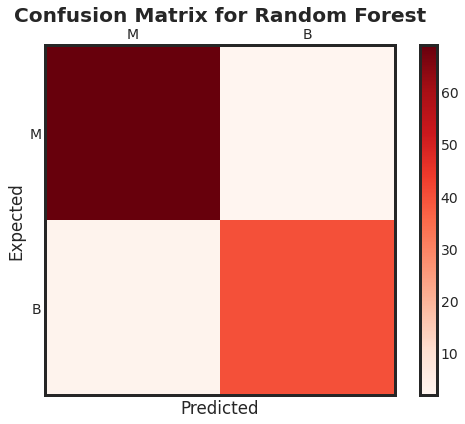

The precision is: 95.24 %
The recall is: 93.02 %


array([[69,  2],
       [ 3, 40]])

In [14]:
# Assign the above probabilities to the corresponding class ('no', 'yes')
rf_class.fit(X_train, y_train)
rf_y_pred = rf_class.predict(X_test)
# Evaluate the model by using Recall/Precission:
getModelEvaluationMetrics(classifier=rf_class, model_name='Random Forest',x_test=X_test, y_test=y_test,
                              y_predicted=rf_y_pred, plot_confusion_matrix=True, figsize=(8,6))

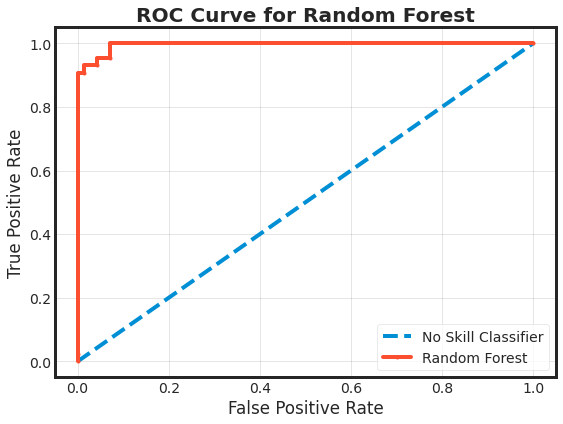

Random Forest - ROC AUC score: 0.9954


0.9954

In [15]:
# Evaluate the model by using ROC Curve:
rf_pred_probs = rf_class.predict_proba(X_test)
createROCAnalysis(classifier=rf_class, model_name='Random Forest', y_test=y_test, pred_probs=rf_pred_probs,
                  plot_ROC_Curve=True, figsize=(8,6))